In [1]:
# import numpy as np
# import os
# buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
#                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
#                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
#                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 
# for building in ["SimpleHouseRad-v0"]:
#     min_v = 0.0
#     max_v = 0.0
#     for round in range(8):
#         for traj_idx in range(2):
#             f_loc = f'data/offline_data/{building}/preferences_data/1/preference_data_{round}_{traj_idx}.pkl'
#             if not os.path.exists(f_loc): continue
#             with open(f_loc, 'rb') as f:
#                 raw_data = np.load(f, allow_pickle=True)
#                 if len(raw_data.shape) > 2: raw_data = raw_data[0]
#             for j in range(raw_data.shape[0]):
#                 min_v = min(min_v, np.min(raw_data[j, :]))
#                 max_v = max(max_v, np.max(raw_data[j, :]))
#     print(building, min_v, max_v)
        

In [2]:
import sys
sys.path.insert(0, "./")

from preference_data import *
from reward_model import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from buildings_factory import *
import pickle
from train import load_reward_model

# buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
#                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
#                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
#                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 

building_name = "SimpleHouseRad-v0"

min_kpis, max_kpis, min_outputs, max_outputs = collect_baseline_kpi(building_name, False)
building_idx = buildings_list.index(building_name)
env = get_env(building_name)
inputs = get_inputs(building_name, env)
default_control = default_controls[building_idx]
env_rl = StableBaselinesRLWrapper(building_name, min_kpis, max_kpis, min_outputs, max_outputs, reward_func, eval=True)
input_dim = env_rl.observation_space.shape[0]

reward_model_loc = "data/models/{}/reward_model/reward_model_best_{}.pkl"
reward_models, _ = load_reward_model(input_dim, reward_model_loc, building_name, "cuda:0")
reward_function = lambda min_kpi, max_kpi, kpi, state: learnt_reward_func(reward_models, min_kpi, max_kpi, kpi, state)
env_rl.reward_function = reward_function
print(env_rl.output_specs)


the initial variables are {'u': 0.0}
the initial variables are {'u': 0.0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1673834994_6106277/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
layer info  [256, 256, 256, 1]
{'weaBus.HDifHor': {'type': 'scalar', 'lower_bound': 0, 'upper_bound': 1000, 'description': 'Horizontal diffuse 

In [3]:
from stable_baselines3 import PPO, SAC
import pickle

round = 2
with open(f'data/offline_data/{building_name}/traj_data/{round}_2.pkl', 'rb') as f:
    trajectories = pickle.load(f)

def sample_trajectory(env, building_name, controller=None):
    building_idx = buildings_list.index(building_name)
    done = False
    state = env.reset()
    step = 0
    trajectory = [state]
    rule_controller = controller_list[building_idx]

    # trajectory.append(state)
    while step <= 288*10:
        # if controller is None: 
        control = env.unwrapped.sample_random_action()
        random_actions = env.transform_action(control)
        if controller is not None:
            actions, _ = controller.predict(state, deterministic=True)
            # _,hour,_,_ = env.unwrapped.get_date()
            # outputs = env.inverse_transform_state(state)
            # control = rule_controller(env.action_keys, step)(outputs, control_values[building_idx], hour)
            # rule_actions = env.transform_action(control)
            noisy_delta = 0.7
            actions = [noisy_delta*ra+(1.0-noisy_delta)*a for ra,a in zip(random_actions, actions)]
        else: actions = random_actions
        # control = {"uHP":[0.1], 'uRSla':[0.1]}
        # actions = env.transform_action(control)
        # print("action: ", actions)
        state, reward, done, info = env.step(actions)
        kpis = env.unwrapped.get_kpi(start_ind=step, end_ind=step+1)
        trajectory.extend([actions, reward, kpis, state])
        # print("control: ", control, "outputs: ", env.outputs)
        # print("state: ", state, " ori:", env.inverse_transform_state(state))
        step += 1
    return trajectory
model_loc = f"data/models/{building_name}/SAC_bs_simulator_seed13/best_model/best_model.zip"
model = SAC.load(model_loc)
# out_df = pd.read_csv("data/models/SwissHouseRSlaW2W-v0/manual_simulator_seed7/logs/best/out.csv")
# for i, row in out_df.iterrows():
#     if i >= 288*2: break
#     outputs = {col:row[col] for col in out_df.columns}
#     state = env_rl.transform_state(outputs)
#     actions, _ = model.predict(state, deterministic=True)
#     print("action: ", env_rl.inverse_transform_action(actions))
    
trajectory = sample_trajectory(env_rl, building_name, controller=model)
# trajectory = trajectories[0]
# env_rl.step(env_rl.transform_action(env_rl.env.sample_random_action()))

# traj_len = 288*1
# for i in range(traj_len):
#     state, action, old_reward, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
#     print("ori action: ", action)
#     print("model action: ", model.predict(state, deterministic=True))

[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1673835001_1942489/resources/0/weather.mos""&##10;"</value></ModelicaMessage>


action:  [-0.36980347633361815] KPI:  {'kpi1': {'name': 'heaPum.P', 'type': 'avg', 'kpi': 3191.16473197937}, 'kpi2': {'name': 'temRoo.T', 'type': 'avg_dev', 'target': [292.15, 297.15], 'kpi': 0.0}, 'kpi3': {'name': 'temRoo.T', 'type': 'tot_viol', 'target': [292.15, 297.15], 'kpi': 0}}
action:  [0.058424341678619346] KPI:  {'kpi1': {'name': 'heaPum.P', 'type': 'avg', 'kpi': 1575.4913091659546}, 'kpi2': {'name': 'temRoo.T', 'type': 'avg_dev', 'target': [292.15, 297.15], 'kpi': 0.0}, 'kpi3': {'name': 'temRoo.T', 'type': 'tot_viol', 'target': [292.15, 297.15], 'kpi': 0}}
action:  [-0.4546031355857849] KPI:  {'kpi1': {'name': 'heaPum.P', 'type': 'avg', 'kpi': 2646.0608541965485}, 'kpi2': {'name': 'temRoo.T', 'type': 'avg_dev', 'target': [292.15, 297.15], 'kpi': 0.0}, 'kpi3': {'name': 'temRoo.T', 'type': 'tot_viol', 'target': [292.15, 297.15], 'kpi': 0}}
action:  [-0.4318466603755951] KPI:  {'kpi1': {'name': 'heaPum.P', 'type': 'avg', 'kpi': 1363.4921610355377}, 'kpi2': {'name': 'temRoo.T', 

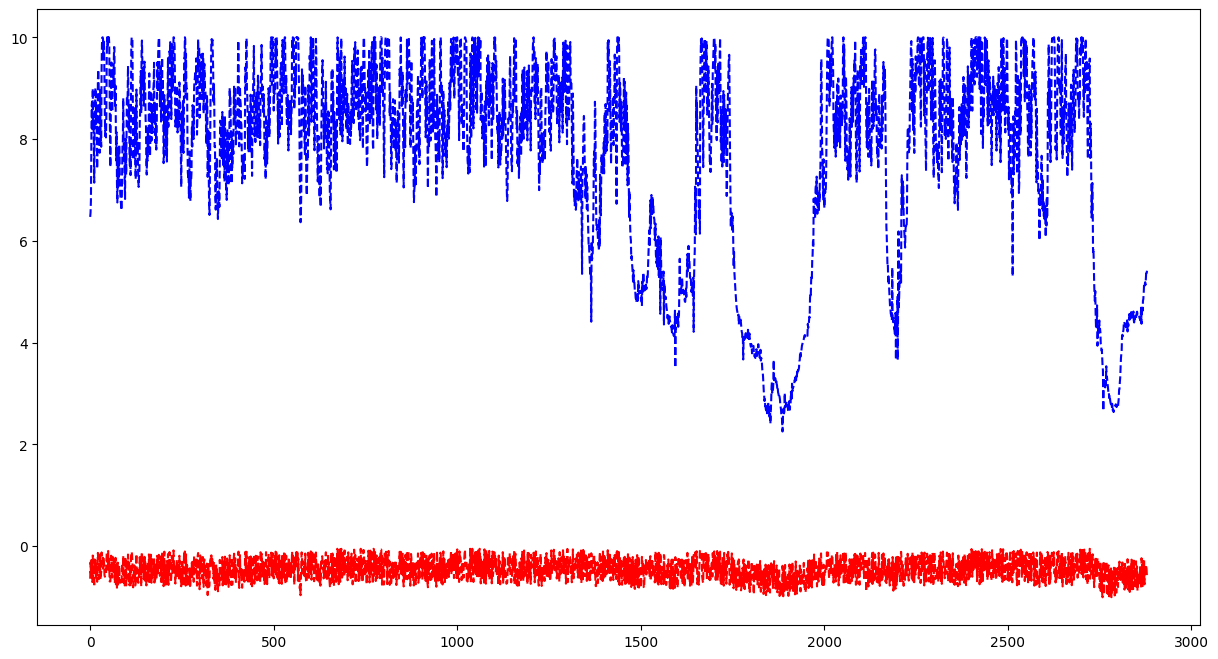

[[1.         0.46167544]
 [0.46167544 1.        ]]


In [4]:
new_traj_reward_list = []
old_traj_reward_list = []
controller = controller_list[building_idx]
out_list = []
cmd_list = []
traj_len = 288*10
for i in range(traj_len):
    state, action, old_reward, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
    old_reward, _ = reward_func(min_kpis, max_kpis, kpis, state)
    # print(old_reward, kpis)
    # print('next_state: ', next_state)
    print("action: ", action, "KPI: ", kpis)
    # print("ori next_state: ", env_rl.inverse_transform_state(next_state))
    old_traj_reward_list.append(old_reward)
    with torch.no_grad():
        # tran = np.concatenate((state, action, next_state))
        # model_in = torch.from_numpy(np.array(next_state)).reshape(1, -1).to(torch.float)
        new_reward, reward_std = reward_function(min_kpis, max_kpis, kpis, next_state)
        new_traj_reward_list.append(new_reward+2*reward_std)
    out_list.append(env_rl.inverse_transform_state(next_state))
    cmd_list.append(env_rl.inverse_transform_action(action))
out_df = pd.DataFrame(out_list)
cmd_df = pd.DataFrame(cmd_list)
plt.figure(figsize=(15, 8))
x = list(range(len(old_traj_reward_list)))
plt.plot(x, old_traj_reward_list, 'r--', x, new_traj_reward_list, 'b--')
# plt.plot(new_traj_reward_list, 'b--')
plt.show()
print(np.corrcoef(old_traj_reward_list, new_traj_reward_list))
# print(new_traj_reward_list)

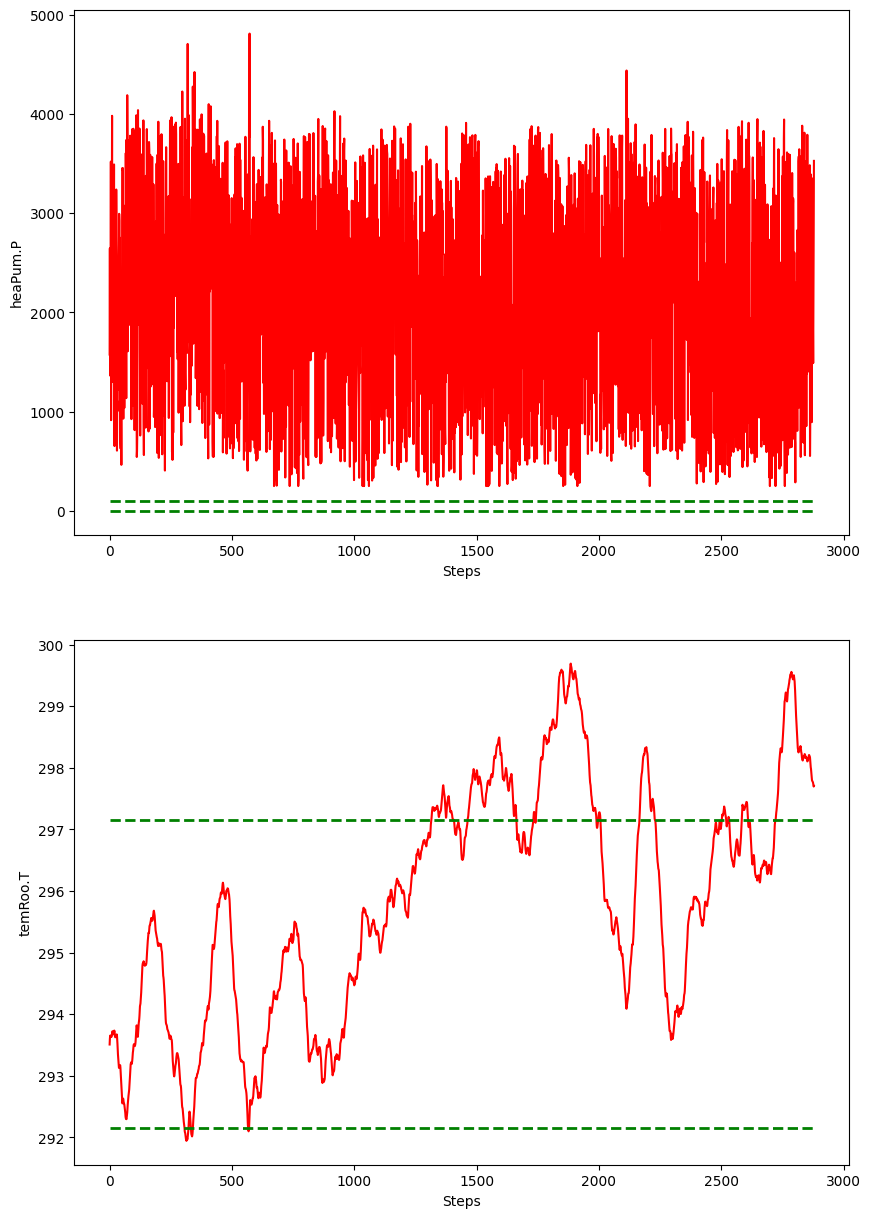

In [5]:
kpi_targets = {}
all_cols_plot = []
for key, val in env_rl.env.kpis.kpi_options.items():
    if "target" in val: kpi_targets[val["name"]] = val["target"]
    if val["name"] not in all_cols_plot: all_cols_plot.append(val["name"])
    
# plot key values
f, axs = plt.subplots(len(all_cols_plot),figsize=(10,15))#
for i, col in enumerate(all_cols_plot):
    axs[i].plot(out_df[col], 'r')
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Steps')
    if col in kpi_targets: intervals = (kpi_targets[col] if isinstance(kpi_targets[col], list) else [kpi_targets[col], kpi_targets[col]])
    elif env_rl.env.output_specs[col]["type"] == "scalar": intervals = [env_rl.env.output_specs[col]['lower_bound'], env_rl.env.output_specs[col]['upper_bound']]
    else: intervals = [0, 0]
    axs[i].plot([0, out_df.shape[0]], [intervals[0], intervals[0]], color='g', linestyle='--', linewidth=2)
    axs[i].plot([0, out_df.shape[0]], [intervals[1], intervals[1]], color='g', linestyle='--', linewidth=2)
    

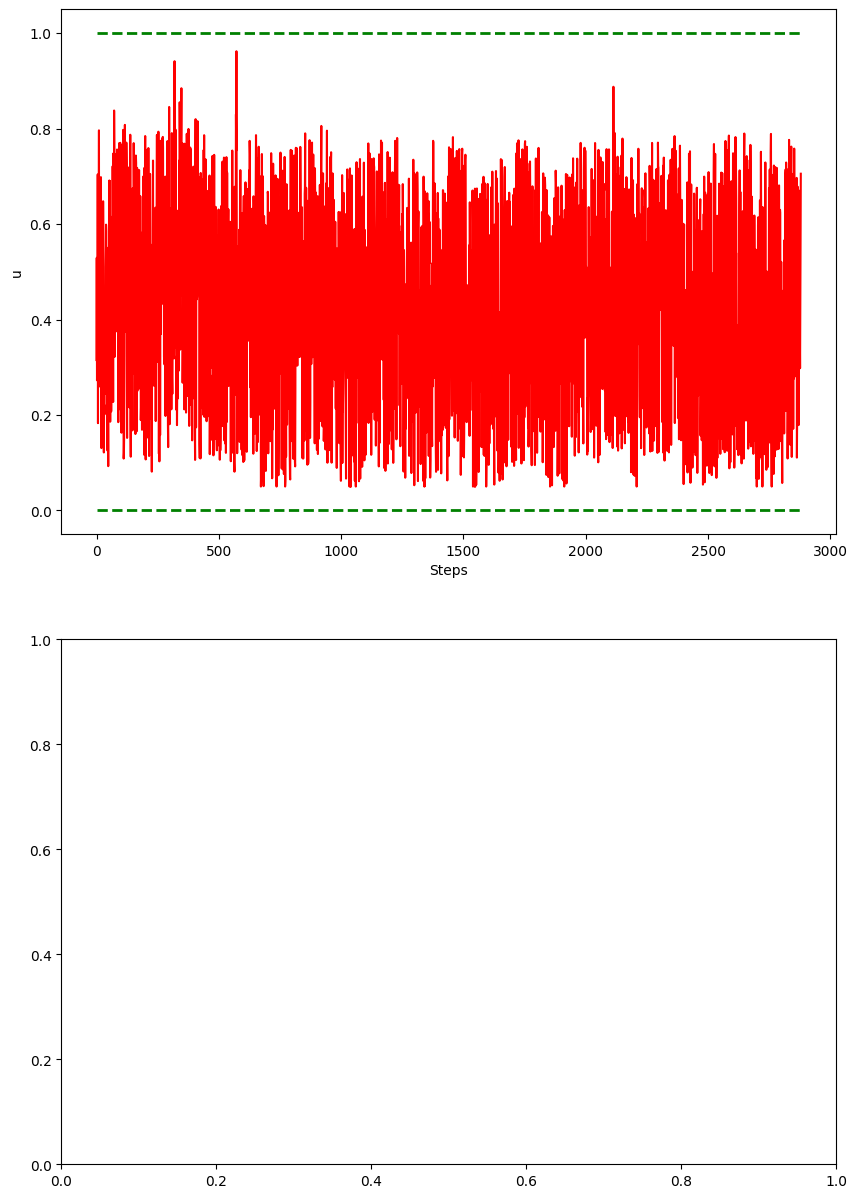

In [6]:
f, axs = plt.subplots(len(inputs)+1,figsize=(10,15))#
for i, col in enumerate(inputs):
    axs[i].plot([x[0] for x in cmd_df[col]], 'r')
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Steps')
    if env_rl.env.input_specs[col]['type'] == 'scalar':
        intervals = [env_rl.env.input_specs[col]['lower_bound'], env_rl.env.input_specs[col]['upper_bound']]
    else: intervals = [0, 0]
    axs[i].plot([0, cmd_df.shape[0]], [intervals[0], intervals[0]], color='g', linestyle='--', linewidth=2)
    axs[i].plot([0, cmd_df.shape[0]], [intervals[1], intervals[1]], color='g', linestyle='--', linewidth=2)
    

In [ ]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# sns.set_theme(style="ticks", palette="pastel")
# fig, ax = plt.subplots(figsize=(10, 8))

# # Load the example tips dataset
# baseline_reward = res_df.loc[res_df["algorithm"]=="baseline", "reward"].mean()
# res_df_rl = res_df.loc[res_df["algorithm"]=="RL", :]
# # Draw a nested boxplot to show bills by day and time
# fig = sns.boxplot(ax=ax, x="building", y="reward",
#             hue="legend", palette=["m", "g", 'r', 'b'],
#             data=res_df_rl)
# fig.axhline(baseline_reward, linewidth=5.0, label="baseline")
# sns.despine(offset=10, trim=True)